In [42]:
# Imports
import os
import datetime
import json
from numpy import *
import pandas as pd
import pyopenms as oms
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm

# Ignore seaborn warning for future deprecation of module part
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import methods from FIA python script
from FIA import *

## Loading
Reads in files

In [43]:
experiment_path = "../data/example data/exampleA_ecolistrains/mg1655_P3-A8_neg.mzXML"
# experiment = read_experiment(experiment_path)

## Data preparation

### Limit spectrum
Limits range and size by subsampling

In [44]:
# lim_exp = limit_experiment(experiment, 51, 1699, 10**6, deepcopy=True)

In [45]:
# quick_plot(spectrum=lim_exp[0], xlim=[60.975, 61.04], plottype="line")

### Smoothing
Can reduce noise, if peaks are non-Gaussian

In [46]:
# smooth_exp = smooth_spectra(lim_exp, 0.01, deepcopy=True)

In [47]:
# quick_plot(spectrum=smooth_exp[0], xlim=[60.975, 61.04], plottype="line")

$\Rightarrow$ Smoothing not needed, as peaks are sufficently on point and approximately gaussian in distribution

### Centroiding
Reduces data, while retaining peaks

In [48]:
# quick_plot(spectrum=smooth_exp[0], xlim=[60.975, 61.04], plottype="scatter")

In [49]:
# centroid_exp = centroid_experiment(experiment, deepcopy=True)

In [50]:
# oms.MzMLFile().store("../runs/centroided_experiment.MzML", centroid_exp)

In [51]:
# quick_plot(spectrum=centroid_exp[0], xlim=[60.975, 61.04], plottype="scatter")

### Merging
Merging spectra in a specified retention time can increase detection

In [52]:
# quick_plot(spectrum=centroid_exp[0])

In [53]:
# merge_exp = merge_spectra(centroid_exp, block_size=centroid_exp.getNrSpectra(), deepcopy=True)

In [54]:
# quick_plot(spectrum=merge_exp[0])

### Normalization
Useful to compare peaks over spectra

In [55]:
# norm_exp = normalize_spectra(merge_exp, deepcopy=True)

In [56]:
# quick_plot(spectrum=norm_exp[0], plottype="line")

### De-isotoping
Adjusting mass/charge-ratio (m/z) for charge and isotopes

In [57]:
# dynamic_plot(norm_exp)

In [58]:
#deisotop_exp = deisotope_experiment(norm_exp,
#                                    fragment_tolerance=0.1, fragment_unit_ppm=False, min_charge=1, max_charge=1,
#                                    keep_only_deisotoped=True, min_isopeaks=2, max_isopeaks=5, make_single_charged=True, annotate_charge=True,
#                                    annotate_iso_peak_count=True, use_decreasing_model=True, start_intensity_check=False, add_up_intensity=False,
#                                    deepcopy=True)

In [59]:
# dynamic_plot(deisotop_exp)

### Merging positive & negative spectra

In [60]:
# merge positive and negative spectra to amplify signals

## Spectrum Alignment

### Obtaining meabolites
All possible metabolites from BiGG, ChEBI, ModelSEED, MetaNetX

In [61]:
# from urllib.request import urlretrieve
# urlretrieve( "http://bigg.ucsd.edu/static/namespace/bigg_models_metabolites.txt", "../data/databases/BiGG/metabolites.txt")
# urlretrieve( "https://ftp.ebi.ac.uk/pub/databases/chebi/Flat_file_tab_delimited/chemical_data.tsv", "../data/databases/ChEBI/chemical_data.tsv")
# urlretrieve( "https://raw.githubusercontent.com/ModelSEED/ModelSEEDDatabase/master/Biochemistry/compounds.tsv", "../data/databases/SEED/compounds.tsv")
# urlretrieve( "https://www.metanetx.org/cgi-bin/mnxget/mnxref/chem_prop.tsv", "../data/databases/MetaNetX/chem_prop.tsv")

### Condense metabolite info
Parse data to obtain a smaller table with metabolite info

In [62]:
# mnx_df = read_mnx("../databases/MetaNetX/chem_prop.tsv")
# mnx_to_oms(mnx_df).to_csv("../databases/compounds.tsv", sep="\t", index=False)

In [63]:
# compounds = pd.read_csv("../data/databases/compounds.tsv", sep="\t")

In [64]:
# join_df_by(mnx_df.dropna().iloc[0:10000], "mass", "name")

MetaNetX is periodically refreshing their database from BiGG, ChEBI, enviPath, HMDB, KEGG, LipidMaps, MetaCyc, Reactome, SABIO-RK, SwissLipids and ModelSEED. Therefore it should hold the most complete database.

### Defining the theoretical spectrum
Assigning theoretical spectra to the metabolites that can be presen. This is more for peptide detection !

In [65]:
#seq = oms.EmpiricalFormula("H6C2H")
#seq_formula = oms.EmpiricalFormula("H6C2H-1")
#isotopes = seq_formula.getIsotopeDistribution(oms.CoarseIsotopePatternGenerator(6))

In [66]:
#print("[M-H]- weight:", seq_formula.getMonoWeight())

### Assign metabolites to spectrum
Detect peaks at metabolite masses and obtain relative prevalence

In [67]:
# 

## Feature Detection

### Untargeted

In [68]:
filepaths = ["../runs/tr_example/centroided_experiment.MzML"]
fms = [ untargeted_feature_detection(filepath=filepath,
                                     feature_filepath="../runs/tr_example/untargeted.featureXML",
                                     mass_error_ppm=10.0,
                                     noise_threshold_int=10000.0,
                                     remove_single_traces="true") 
        for filepath in filepaths ]
fms_rt = align_retention_times(fms)
fms_a = detect_adducts(fms_rt)

Progress of 'mass trace detection':
-- done [took 0.02 s (CPU), 0.00 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.07 s (CPU), 0.01 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 0.04 s (CPU), 0.01 s (Wall)] -- 
MassExplainer table size: 312
Generating Masses with threshold: -6.90776 ...
done
2 of 4 valid net charge compomer results did not pass the feature charge constraints
Inferring edges raised edge count from 2 to 2
Found 2 putative edges (of 23) and avg hit-size of 2.5
Using solver 'coinor' ...
Optimal solution found!
 Branch and cut took 0.000652 seconds,  with objective value: 0.12.
ILP score is: 0.12
Agreeing charges: 4/4


In [69]:
# store_feature_maps(fms_a)

### Build Consensus

In [70]:
# cm = consensus_features(fms_a)
# oms.ConsensusXMLFile().store("../runs/FeatureMatrix_.consensusXML", cm)

In [71]:
# df = cm.get_df()
# df

#### Link metabolites to features

In [72]:
# Link it 

### Targeted
Give a list of metabolites with mass, charge and retention time to feature finder

In [74]:
mt = define_metabolite_table("../databases/compounds.tsv", [50.0, 3000.0])
len(mt)

1048469

In [75]:
fm = feature_detection_targeted("../runs/tr_example/centroided_experiment.MzML", mt[0:100], mz_window=5.0, rt_window=200.0, peak_width=3.0)

RT window size calculated as 240 seconds.
Extracting chromatograms...
Detecting chromatographic peaks...
Found 536 feature candidates in total.
92 features left after selection of best candidates.
Model fitting: 1 successes, 44 failures
Imputing model failures with a linear model based on log(rawIntensities). Slope: 1, Intercept: 0.207468


Error: Invalid charge 0 for target '6Z,9Z-Heneicosadien-11-one' - skipping this charge.
Error: Invalid charge 0 for target '4,10-Dimethyltriacontane' - skipping this charge.
Error: Invalid charge 0 for target '9,13-Dimethylheptacosane' - skipping this charge.
Error: Invalid charge 0 for target 'trans-4S,5S-Epoxy-6Z,9Z-nonadecadiene' - skipping this charge.
Error: Invalid charge 0 for target '(Z)-3-Decenyl (E)-2-hexenoate' - skipping this charge.
Error: Invalid charge 0 for target '9Z-Hexadecenyl acetate' - skipping this charge.
Error: Invalid charge 0 for target '2S-Hydroxyoctan-3-one' - skipping this charge.
Error: Invalid charge 0 for target '7,7-Difluoro-8Z-dodecenyl acetate' - skipping this charge.


In [76]:
# fm = targeted_feature_detection("../runs/centroided_experiment.MzML", centroid_exp, "../data/databases/compounds.tsv", mz_window=5.0, rt_window=500.0, peak_width=3.0)
oms.FeatureXMLFile().store("../runs/tr_example/targeted.featureXML", fm)

### Feature annotation by accurate mass

In [77]:
import shutil
import requests
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# set path to your mzML files, or leave like this to use the example data
run_dir = "../runs/tr1"
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

# build_directory(run_dir)

In [78]:
base = "https://abibuilder.cs.uni-tuebingen.de/archive/openms/Tutorials/Example_Data/Metabolomics/"
urls = [
    "datasets/2012_02_03_PStd_050_1.mzML",
    "datasets/2012_02_03_PStd_050_2.mzML",
    "datasets/2012_02_03_PStd_050_3.mzML",
    "databases/PositiveAdducts.tsv",
    "databases/NegativeAdducts.tsv",
    "databases/HMDBMappingFile.tsv",
    "databases/HMDB2StructMapping.tsv",
]

# batch_download(base, urls, run_dir)

In [79]:
# run_dir = centroid_batch(run_dir, file_ending=".mzML")
run_dir = os.path.normpath(os.path.join(os.getcwd(), os.path.join(run_dir, "centroids")))

In [80]:
feature_maps = untargeted_features_detection(run_dir, ".mzML", 
                                            mass_error_ppm=10.0, noise_threshold_int=1000.0,
                                            width_filtering="fixed", isotope_filtering_model="none", remove_single_traces="true",
                                            mz_scoring_by_elements="false", report_convex_hulls="true")

Progress of 'mass trace detection':
-- done [took 0.02 s (CPU), 0.00 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.01 s (CPU), 0.00 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 0.01 s (CPU), 0.00 s (Wall)] -- 


In [81]:
feature_maps = align_retention_times(feature_maps, 
                                    max_num_peaks_considered=-1,      # -1 -> consider infinite/all peaks
                                    max_mz_difference=10.0,
                                    mz_unit="ppm")

In [82]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

/tmp/ipykernel_23087/2928129684.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


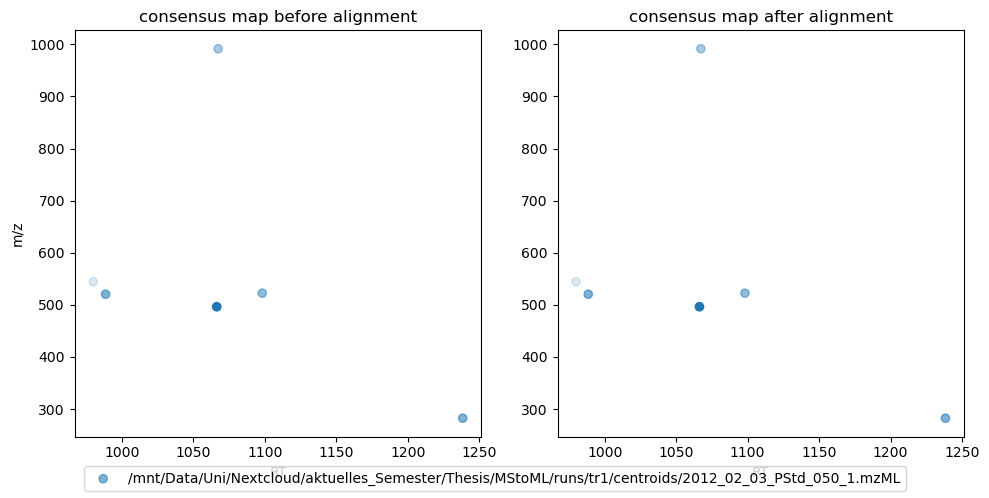

In [86]:
plot_feature_map_rt_alignment(feature_maps)

# HERE !

In [ ]:
feature_grouper = oms.FeatureGroupingAlgorithmQT()

consensus_map = oms.ConsensusMap()
file_descriptions = consensus_map.getColumnHeaders()

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, oms.ColumnHeader())
    file_description.filename = feature_map.getMetaValue("spectra_data")[
        0
    ].decode()
    file_description.size = feature_map.size()
    file_description.unique_id = feature_map.getUniqueId()
    file_descriptions[i] = file_description

consensus_map.setColumnHeaders(file_descriptions)
feature_grouper.group(feature_maps, consensus_map)

RuntimeError: At least two maps must be given!

In [ ]:
intensities = consensus_map.get_intensity_df()

meta_data = consensus_map.get_metadata_df()[["RT", "mz", "quality"]]

cm_df = pd.concat([meta_data, intensities], axis=1)
cm_df.reset_index(drop=True, inplace=True)
cm_df

In [ ]:
if files.endswith("centroid"):
    files = os.path.join(files, "..")

ams = oms.AccurateMassSearchEngine()

ams_params = ams.getParameters()
ams_params.setValue("ionization_mode", "negative")
ams_params.setValue(
    "positive_adducts", os.path.join(files, "PositiveAdducts.tsv")
)
ams_params.setValue(
    "negative_adducts", os.path.join(files, "NegativeAdducts.tsv")
)
ams_params.setValue("db:mapping", [os.path.join(files, "HMDBMappingFile.tsv")])
ams_params.setValue(
    "db:struct", [os.path.join(files, "HMDB2StructMapping.tsv")]
)
ams.setParameters(ams_params)

mztab = oms.MzTab()

ams.init()

ams.run(consensus_map, mztab)

oms.MzTabFile().store(os.path.join(files, "ids.tsv"), mztab)

with open(os.path.join(files, "ids_smsection.tsv"), "w") as output, open(
    os.path.join(files, "ids.tsv"), "r"
) as input:
    for line in input:
        if line.lstrip().startswith("SM"):
            output.write(line[4:])

ams_df = pd.read_csv(os.path.join(files, "ids_smsection.tsv"), sep="\t")

os.remove(os.path.join(files, "ids.tsv"))
os.remove(os.path.join(files, "ids_smsection.tsv"))

ams_df

In [ ]:
allowed_missing_values = 1
min_feature_quality = 0.8
n_nearest_neighbours = 2

# drop features that have more then the allowed number of missing values or are below minimum feature quality
to_drop = []

for i, row in cm_df.iterrows():
    if (
        row.isna().sum() > allowed_missing_values
        or row["quality"] < min_feature_quality
    ):
        to_drop.append(i)

cm_df.drop(index=cm_df.index[to_drop], inplace=True)

# Data imputation with KNN
imputer = Pipeline(
    [
        ("imputer", KNNImputer(n_neighbors=2)),
        (
            "pandarizer",
            FunctionTransformer(
                lambda x: pd.DataFrame(x, columns=cm_df.columns)
            ),
        ),
    ]
)

cm_df = imputer.fit_transform(cm_df)
cm_df

In [ ]:
id_df = cm_df

id_df["identifications"] = pd.Series(["" for x in range(len(id_df.index))])

for rt, mz, description in zip(
    ams_df["retention_time"],
    ams_df["exp_mass_to_charge"],
    ams_df["description"],
):
    indices = id_df.index[
        isclose(id_df["mz"], float(mz), atol=1e-05)
        & isclose(id_df["RT"], float(rt), atol=1e-05)
    ].tolist()
    for index in indices:
        if description != "null":
            id_df.loc[index, "identifications"] += str(description) + ";"
id_df["identifications"] = [
    item[:-1] if ";" in item else "" for item in id_df["identifications"]
]
id_df.to_csv(os.path.join(files, "result.tsv"), sep="\t", index=False)
id_df

In [ ]:
fig = px.scatter(id_df, x="RT", y="mz", hover_name="identifications")
fig.update_layout(title="Consensus features with identifications (hover)")
fig.show()

### Plot

In [ ]:
def extract_feature_coord(feature:oms.Feature, mzs:array, retention_times:array, intensities:array, labels:array, sub_feat:oms.Feature) -> list:
    if sub_feat:
        for i, hull_point in enumerate(sub_feat.getConvexHulls()[0].getHullPoints()):
            mzs = append(mzs, sub_feat.getMZ())
            retention_times = append(retention_times, hull_point[0])
            intensities = append(intensities, hull_point[1])
            labels = append(labels, feature.getMetaValue('label'))
    else:    
        mzs = append(mzs, feature.getMZ())
        retention_times = append(retention_times, feature.getRT())
        intensities = append(intensities, feature.getIntensity())
        labels = append(labels, feature.getMetaValue("label"))
        

    return [mzs, retention_times, intensities, labels]

def plot_features_3D(feature_map:oms.FeatureMap, plottype:str=None) -> None:
    """
    Represents found features in 3D
    """
    mzs = empty([0])
    retention_times = empty([0])
    intensities = empty([0])
    labels = empty([0])

    for feature in feature_map:
        if feature.getSubordinates():
            for i, sub_feat in enumerate(feature.getSubordinates()):
                mzs, retention_times, intensities, labels = extract_feature_coord(feature, mzs, retention_times, intensities, labels, sub_feat)
        else:
            mzs, retention_times, intensities, labels = extract_feature_coord(feature, mzs, retention_times, intensities, labels)

    df = pd.DataFrame({"m/z": mzs, "rt": retention_times, "intensity": intensities, "labels": labels})
    
    if plottype == "surface":
        fig = go.Figure(data=[go.Surface(z=df)])
        fig.update_layout(title='3D plot of features', autosize=True,
                    width=500, height=500,
                    xaxis_title="m/z", yaxis_title="rt",
                    margin=dict(l=65, r=50, b=65, t=90),
                    scene = {
                            "aspectratio": {"x": 1, "y": 1, "z": 0.2}
                            })
    elif plottype == "line":
        fig = px.line_3d(data_frame=df, x="m/z", y="rt", z="intensity", color="labels")
    elif plottype == "scatter":
        fig = px.scatter_3d(data_frame=df, x="m/z", y="rt", z="intensity", color="labels", size_max=1)
 
    if plottype:
        fig.update_traces(showlegend=False)        
        fig.show()
    
    return df

In [ ]:
feature_map = read_feature_map_XML("../runs/targeted.featureXML")

In [ ]:
df = plot_features_3D(feature_map, plottype="line")

In [ ]:
df

,m/z,rt,intensity,labels
0,102.674924,0.000000,8.018,(2E)-geranyl diphosphate
1,102.674924,159.001266,8.733,(2E)-geranyl diphosphate
2,103.009375,0.000000,8.018,(2E)-geranyl diphosphate
3,103.009375,232.764114,8.733,(2E)-geranyl diphosphate
4,159.025499,0.000000,5.161,(3-hydroxy-2-oxindol-3-yl)acetyl-L-aspartate
...,...,...,...,...
1073,330.547834,0.000000,10.162,NADH
1074,330.547834,0.000000,10.876,NADH
1075,331.049511,0.000000,9.447,NADH
1076,331.049511,2743.003174,10.162,NADH


In [ ]:
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')
z_data.values.shape

In [ ]:
feature = feature_map[0]